In [1]:
import numpy as np
from epi_models import *
from eulerverfahren import *
from matplotlib import pyplot as plt
from utils import *
import os
from pandas import read_csv
import shutil
from matplotlib.animation import FuncAnimation
from IPython.display import display, Latex
%matplotlib widget

## Hinweis:
<font size="3">Für dieses Notebook genügt es, nacheinander den Code aller Zellen auszuführen. Es ist nicht notwendig, weitere Einstellungen vorzunehmen.

## ====== Experimentkonfiguration ======
<font size="3">Die folgende Experimentkonfiguration entspricht der Basiskonfiguration des Kapitels 5.1 *Reaktion ohne Diffusion* ergänzt um $\kappa_{\text{Muster}}$ und $\beta_{\text{homo}}$ als Kontakt- bzw. Wahrscheinlichkeitsmatrix.

In [2]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ~~~~~ Bevölkerungsstruktur ~~~~~
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Bevölkerungsgröße
N = 10000

# Blutgruppen
f_B = get_blutgruppenverteilung()    # Anteile der Blutgruppen AB, A, B und 0
Nb = f_B.shape[0]                    # Anzahl an Blutgruppen

# Altersgruppen
f_A = get_altersverteilung()         # Anteile der Altersklassen 0-4Jahre, 5-9Jahre, ...., 80+ Jahre
Na = f_A.shape[0]                    # Anzahl an Altersgruppen

# Kombinierte Verteilung der Altersklassen und Blutgruppen
f_AB = np.tensordot(f_A,f_B, axes=0)

In [3]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ~~~~~~~~ Modellparameter ~~~~~~~~
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Skalierte Kontraktrate Lambda
# 1) Kontaktmatrix kappa                                
kappa = get_contact_matrix(a=1)                        # Kontaktmatrix: kappa_Muster
# 2) Wahrscheinlichkeitsmatrix beta
b = 0.03                                               # Basiswahrscheinlichkeit einer Ansteckung bei Kontakt                                        
beta = b*np.ones((Nb,Nb))                              # Wahrscheinlichkeitsmatrix: beta_inhomo
# 1) + 2) => Skalierte Kontaktrate
lamda = get_lamda_scaled(kappa, beta, f_B, f_AB, N)    # Skalierte Kontakrate: lambda       

# Genesungsrate Gamma
gamma = 1.0 / np.array([6]*Na)                         # Genesungsrate: gamma

In [4]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ~~~~~~~~~ Anfangswerte ~~~~~~~~~
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Anfangswert für das Kompartiment der Infizierten
# Zu Beginn ist genau ein Individuum aus Altersklasse 25-29 Jahre mit Blutgruppe A infiziert.
I0 = np.zeros((Na,Nb)) 
I0[5,1] = 1  

# Anfangswert für das Kompartiment der Suszeptiblen
S0 = N * f_AB - I0

# Kombinierter Anfangswert
A0 = np.stack((S0,I0))

In [5]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ~~~~~~~~~ Zeitdiskretisierung ~~~~~~~~~
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

T = 200    # Einheit Tage
Nt = T*2   # (Nt+1) viele Zeitpunkte werden berechnet

In [6]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ~~~~~~~~~ Konfiguration des rangadaptiven Eulerverfahrens ~~~~~~~~~
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Hierarchischer Rang
max_rank_k = 30            
max_rank_r = 30

# Konstanten
M1 = 1e-1
M2 = 1e-1

# Resultierende Fehlertoleranzen
eps_k = (M2 * (T/Nt)**2)/2    
eps_r = (M1 * (T/Nt))/4       

In [7]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ~~~~~~~~~ Übersicht ~~~~~~~~~
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

print("~~~ Population ~~~")
print("Populationsgröße: ", N)
print("Anzahl Altersklassen: ", Na)
print("Altersklassenverteilung: ", f_A)
print("Anzahl Blutgruppen: ", Nb)
print("Blutgruppenverteilung: ", f_B)
print("~~~ Parameter ~~~")
print("Kontakte rein zufällig: ", np.allclose(np.repeat(f_A[:,None], Na, 1), kappa / (np.sum(kappa, axis=0))[:,None]))
print("Ansteckung unabhängig von Blutgruppen: ", np.allclose(beta, beta[0,0]))
print("Genesung unabhängig von Alter: ", np.allclose(gamma, gamma[0]))
print("Tägliche Kontakte pro Individuum: ", np.sum(f_A*np.sum(kappa,axis=0)))
print("Ansteckungswahrscheinlichkeit bei Kontakt: ", np.sum(f_B * np.sum(f_B[None,:] * beta, axis=1)))
print("Durchschnittliche skalierte Kontaktrate: ", np.tensordot(f_AB, np.sum(lamda, axis=(0,1))))
print("Durchschnittliche unskalierte Kontaktrate: ", np.tensordot(f_AB, np.sum(lamda*(N*f_AB)[:,:,None,None], axis=(0,1))))
print("Gamma avg: ", np.sum(f_A*gamma))
print("Durchschnittliche Kontaktzahl: ", np.tensordot(f_AB, np.sum((lamda*N*f_AB[:,:,None,None])/gamma[None,None:,None], axis=(0,1))))
print("~~~ Zeit ~~~")
print("Zeitintervall [0,{}]".format(T))
print("tau: ", T/Nt)
print("~~~ HTucker ~~~")
print("Fehlerschranke eps_k: ", eps_k)
print("Fehlerschranke eps_r: ", eps_r)

~~~ Population ~~~
Populationsgröße:  10000
Anzahl Altersklassen:  17
Altersklassenverteilung:  [0.04728 0.04825 0.04587 0.04661 0.0537  0.05947 0.06616 0.06531 0.06298
 0.05785 0.0705  0.08131 0.07353 0.06021 0.05122 0.03729 0.07246]
Anzahl Blutgruppen:  4
Blutgruppenverteilung:  [0.05 0.43 0.11 0.41]
~~~ Parameter ~~~
Kontakte rein zufällig:  False
Ansteckung unabhängig von Blutgruppen:  True
Genesung unabhängig von Alter:  True
Tägliche Kontakte pro Individuum:  9.477345600148999
Ansteckungswahrscheinlichkeit bei Kontakt:  0.03
Durchschnittliche skalierte Kontaktrate:  0.00196106600227139
Durchschnittliche unskalierte Kontaktrate:  0.28432036800447
Gamma avg:  0.16666666666666669
Durchschnittliche Kontaktzahl:  1.70592220802682
~~~ Zeit ~~~
Zeitintervall [0,200]
tau:  0.5
~~~ HTucker ~~~
Fehlerschranke eps_k:  0.0125
Fehlerschranke eps_r:  0.0125


##  ====== Modellinitialisierung ======

In [8]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ~~~~~~~~~ Vorbereitung des Verzeichnis für die Ergebnisdaten ~~~~~~~~~
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

del_if_exists = True
experiment_name = "kappa_muster_beta_homo"
dirname_full = os.path.join("ergebnisse", "ode_reaktion", experiment_name, "full")
dirname_ht = os.path.join("ergebnisse", "ode_reaktion", experiment_name, "ht")
if os.path.isdir(dirname_full) and del_if_exists:
    shutil.rmtree(dirname_full)
if os.path.isdir(dirname_ht) and del_if_exists:
    shutil.rmtree(dirname_ht)

In [9]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ~~~~~~~~~ Initialisierung der beiden Modelle mit vollen Tensoren und HTucker Tensoren ~~~~~~~~~
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Modell mit vollen Tensoren
model_full = ExtendedSIRModelNoDiff(A0, lamda, gamma)
model_full.set_population_settings(N, f_A, f_B, f_AB)
model_full.set_time_discretization(T, Nt)
# Outputhandler für volles Modell
# Definiert welche der Informationen, die während der Simulation anfallen, gespeichert werden
oh_full = OutputHandler(path=".", dname=dirname_full, model=model_full, standard_output=True)
oh_full.prepare_dir()
oh_full.write_settings(model_full.__dict__)

# Modell mit hierarchischen Tuckertensoren
model_ht = ExtendedSIRModelHTuckerNoDiff(A0, lamda, gamma)
model_ht.set_population_settings(N, f_A, f_B, f_AB)
model_ht.set_time_discretization(T, Nt)
model_ht.set_htucker_settings(mrs=max_rank_k, mrd=max_rank_r, aes=eps_k, aed=eps_r)
model_ht.truncate_A0()
model_ht.prepare_lamda()
# Outputhandler für Modell mit hierarchischen Tuckertensoren
# Definiert welche der Informationen, die während der Simulation anfallen, gespeichert werden
oh_ht = OutputHandler(path=".", dname=dirname_ht, model=model_ht, standard_output=True)
oh_ht.prepare_dir()
oh_ht.write_settings(model_ht.__dict__)

# Klassisches SIR-Modell mit gemittelter skalierter Kontaktrate Lamda
# und gemittelter Genesungsrate Gamma.
lamda_avg_skaliert =  np.tensordot(f_AB, np.sum(lamda*(N*f_AB)[:,:,None,None], axis=(0,1)))/N
gamma_avg = np.sum(f_A*gamma)
sigma_avg = np.tensordot(f_AB, np.sum((lamda*N*f_AB[:,:,None,None])/gamma[None,None,:,None], axis=(0,1)))
model_sir = SIRClassic(np.stack((np.sum(S0), np.sum(I0))),N,lamda_avg_skaliert, gamma_avg)
model_sir.set_time_discretization(T,Nt)

## ====== Simulationsberechnung ======

In [10]:
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# ~~~~~~~~~ Berechnung ~~~~~~~~
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# Volle Tensoren
EE_full = ExplizitesEulerverfahren(model_full, oh_full)
EE_full.compute()

# HTucker Tensoren
EE_ht = RangadaptivesEulerverfahren(model_ht, oh_ht)
EE_ht.compute()

# Klassisches SIR-Modell mit gemittelter skalierter Kontaktrate Lamda und gemittelter Genesungsrate Gamma.
# Berechne klassisches SIR-Modell auf Grundlage obiger Anfangswerte und Durchschnittsparameter
A_klassisch = model_sir.compute()
A_klassisch = np.stack((A_klassisch[:,0], A_klassisch[:,1], N - (A_klassisch[:,0]+A_klassisch[:,1])))

100%|████████████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 100037.06it/s]


## ====== Auswertung ======

### 1) Auswahl des Experiments, dessen Lösung betrachtet werden soll

In [11]:
# Einladen der Ergebnisdaten

# Lösung des Modells mit vollen Tensoren
S_full = np.array(load(os.path.join(dirname_full, "S")))
I_full = np.array(load(os.path.join(dirname_full, "I")))
R_full = N * f_AB - (S_full+I_full)
# Speicherbedarf des Modells mit vollen Tensoren
Speicher_full = {"S": np.array([S.nbytes/1e6 for S in S_full])}
Speicher_full["I"] = np.array([I.nbytes/1e6 for I in I_full])

# Lösung des Modells mit hierarchischen Tuckertensoren
S_ht = np.array(load(os.path.join(dirname_ht, "S")))
I_ht = np.array(load(os.path.join(dirname_ht, "I")))
# Speicherbedarf des Modells mit hierarchischen Tuckertensoren
Speicher_ht = {"S": np.array([S.get_size()/1e6 for S in S_ht])}
Speicher_ht["I"] = np.array([I.get_size()/1e6 for I in I_ht])
# Hierarchische Ränge
Rank = {"S": np.array([max(S.rank.values()) for S in S_ht])}
Rank["I"] = np.array([max(I.rank.values()) for I in I_ht])

# Von Theorie vorhergesagte Maximalprävalenz
I_max = round(get_i_max(R0=np.sum(R_full[0])/N, S0=np.sum(S_full[0])/N, sigma=sigma_avg)*N)
# Von Theorie vorhergesagte Endanzahl an Suszeptiblen
S_inf = round(get_s_inf(R0=np.sum(R_full[0])/N, S0=np.sum(S_full[0])/N, sigma=sigma_avg)*N)

### 2) Makroskopischer Verlauf: RE vs. EE vs. SIR klassisch

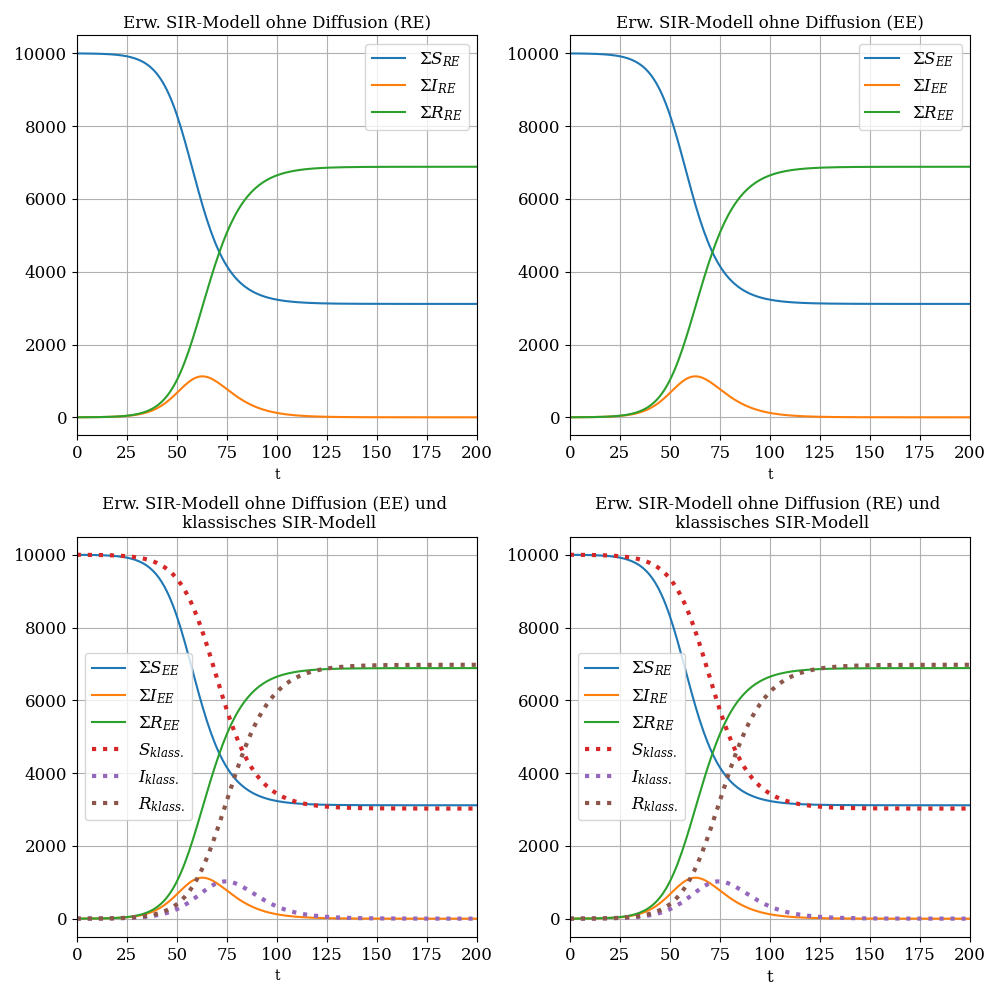

In [12]:
# Plot
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.close("all")
xaxis = np.arange(0,I_ht.shape[0])
fig, axes = plt.subplots(nrows = 2, ncols=2, figsize=(10, 10))
((ax0, ax1), (ax2, ax3)) = axes
# Axis 0
ax0.plot(xaxis, [np.sum(S.full(), axis=(0,1)) for S in S_ht], label="$\Sigma S_{RE}$")
ax0.plot(xaxis, [np.sum(I.full(), axis=(0,1)) for I in I_ht], label="$\Sigma I_{RE}$")
ax0.plot(xaxis, [N - np.sum(S_ht[i].full()+I_ht[i].full(), axis=(0,1)) for i in range(len(S_ht))], label="$\Sigma R_{RE}$")
ax0.set_title("Erw. SIR-Modell ohne Diffusion (RE)")
ax0.set_xlabel("t")
ax0.grid()
ax0.set_xlim(0,T)
ax0.legend(fontsize=12)
ax0.tick_params(axis='both', which='major', labelsize=12)
# Axis 1
ax1.plot(xaxis, np.sum(S_full, axis=(1,2)), label="$\Sigma S_{EE}$")
ax1.plot(xaxis, np.sum(I_full, axis=(1,2)), label="$\Sigma I_{EE}$")
ax1.plot(xaxis, np.sum(R_full, axis=(1,2)), label="$\Sigma R_{EE}$")
ax1.set_title("Erw. SIR-Modell ohne Diffusion (EE)")
ax1.set_xlabel("t")
ax1.grid()
ax1.set_xlim(0,T)
ax1.legend(fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=12)
# Axis 2
ax2.plot(xaxis, np.sum(S_full, axis=(1,2)), label="$\Sigma S_{EE}$")
ax2.plot(xaxis, np.sum(I_full, axis=(1,2)), label="$\Sigma I_{EE}$")
ax2.plot(xaxis, np.sum(R_full, axis=(1,2)), label="$\Sigma R_{EE}$")
ax2.plot(xaxis, A_klassisch[0,:], label="$S_{klass.}$", linestyle="dotted", linewidth=3)
ax2.plot(xaxis, A_klassisch[1,:], label="$I_{klass.}$", linestyle="dotted", linewidth=3)
ax2.plot(xaxis, A_klassisch[2,:], label="$R_{klass.}$", linestyle="dotted", linewidth=3)
ax2.set_title("Erw. SIR-Modell ohne Diffusion (EE) und \n klassisches SIR-Modell")
ax2.set_xlabel("t")
ax2.grid()
ax2.set_xlim(0,T)
ax2.legend(fontsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)
# Axis 3
ax3.plot(xaxis, [np.sum(S.full(), axis=(0,1)) for S in S_ht], label="$\Sigma S_{RE}$")
ax3.plot(xaxis,[np.sum(I.full(), axis=(0,1)) for I in I_ht], label="$\Sigma I_{RE}$")
ax3.plot(xaxis,[N - np.sum(S_ht[i].full()+I_ht[i].full(), axis=(0,1)) for i in range(len(S_ht))], label="$\Sigma R_{RE}$")
ax3.plot(xaxis, A_klassisch[0,:], label="$S_{klass.}$", linestyle="dotted", linewidth=3)
ax3.plot(xaxis, A_klassisch[1,:], label="$I_{klass.}$", linestyle="dotted", linewidth=3)
ax3.plot(xaxis, A_klassisch[2,:], label="$R_{klass.}$", linestyle="dotted", linewidth=3)
ax3.set_title("Erw. SIR-Modell ohne Diffusion (RE) und \n klassisches SIR-Modell")
ax3.set_xlabel("t", fontsize=12)
ax3.grid()
ax3.set_xlim(0,T)
ax3.legend(fontsize=12)
ax3.tick_params(axis='both', which='major', labelsize=12)
fig.tight_layout(pad=1.0)

### 3) Verlauf der relativen Prävalenz: Blutgruppenstratifiziert

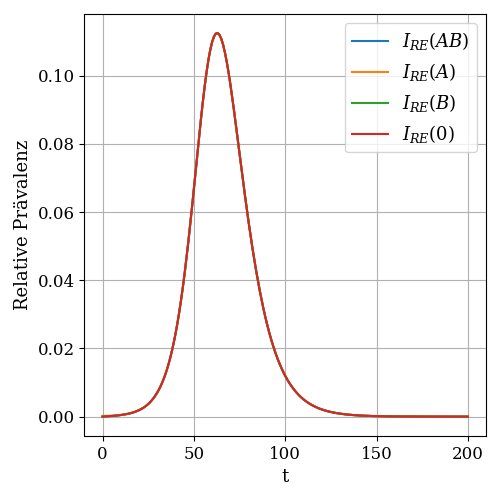

In [13]:
# Verlauf der relativen Prävalenz pro Blutgruppe

# Plot
fig, axes = plt.subplots(nrows = 1, ncols=1, figsize=(5, 5))
x_axis = np.arange(Speicher_ht["I"].shape[0])
axes.plot(xaxis,  [np.sum(I.full(), axis=(0))[0]/(N*f_B[0]) for I in I_ht], label="$I_{RE}(AB)$")
axes.plot(xaxis, [np.sum(I.full(), axis=(0))[1]/(N*f_B[1]) for I in I_ht], label="$I_{RE}(A)$")
axes.plot(xaxis, [np.sum(I.full(), axis=(0))[2]/(N*f_B[2]) for I in I_ht], label="$I_{RE}(B)$")
axes.plot(xaxis, [np.sum(I.full(), axis=(0))[3]/(N*f_B[3]) for I in I_ht], label="$I_{RE}(0)$")
axes.tick_params(axis='both', which='major', labelsize=12)
axes.legend(fontsize=13)
axes.grid()
axes.set_ylabel("Relative Prävalenz", fontsize=13)
axes.set_xlabel("t", fontsize=13)
fig.tight_layout(pad=1.0)

### 4) Verlauf der relativen Prävalenz: Altersklassenstratifiziert

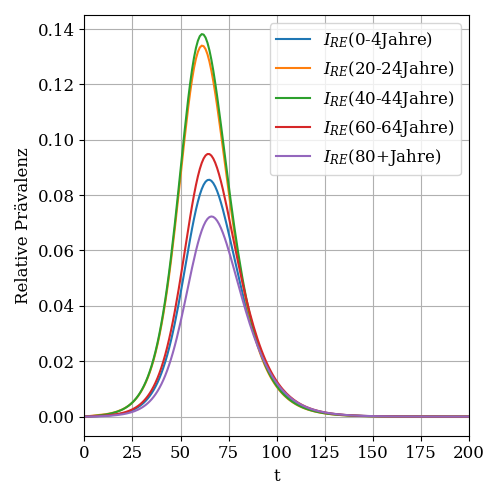

In [14]:
# Verlauf der relativen Prävalenz für 5 ausgewählte Altersklassen
idc= [0,4,8,12,16]
#Plot
plt.rcParams["figure.figsize"] = [5,5]
plt.rcParams["figure.autolayout"] = True
xaxis = np.arange(0,S_full.shape[0],1)
plt.close("all")
for idx in idc:
    if idx <16:
        altersklasse = "{}-{}Jahre".format(5*idx,4+5*idx)
    else:
        altersklasse ="80+Jahre"
    plt.plot(xaxis, np.sum(I_full, axis=2)[:,idx]/(N*f_A[idx]), label="$I_{RE}$"+"({})".format(altersklasse))
plt.ylabel("Relative Prävalenz", fontsize=12)
plt.xlabel("t", fontsize=12)
plt.grid()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(0,T)
plt.legend(fontsize=12);

### 5) Speicherbedarf: RE vs. EE

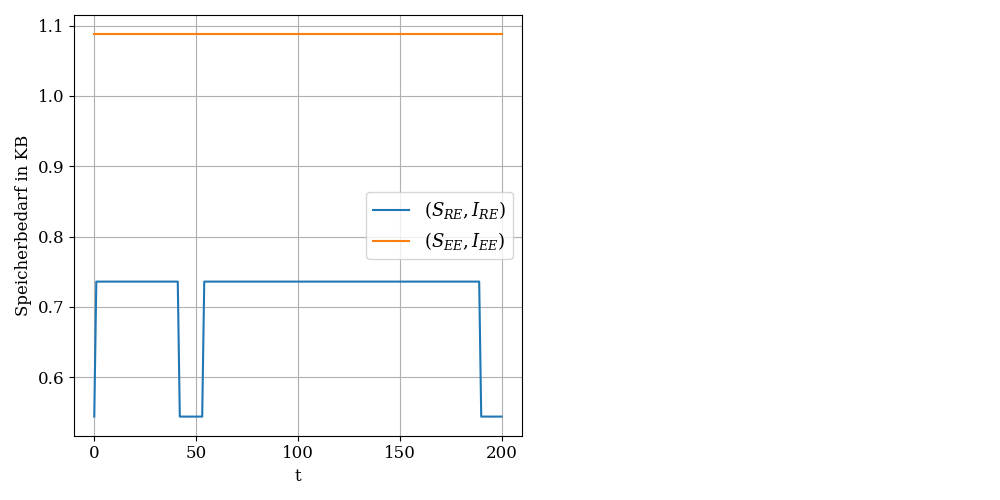

In [21]:
# Speicherbedarf
fig, axes = plt.subplots(nrows = 1, ncols=2, figsize=(10, 5))
ax1, ax2 = axes
# Plot 1: Speicherbedarf Lösung
x_axis = np.arange(Speicher_full["S"].shape[0])
ax1.plot(x_axis, (Speicher_ht["S"]+Speicher_ht["I"])*1000, label="$(S_{RE},I_{RE})$")
ax1.plot(x_axis, (Speicher_full["S"]+Speicher_full["I"])*1000, label="$(S_{EE},I_{EE})$")
ax1.legend(fontsize=13)
ax1.grid()
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_ylabel("Speicherbedarf in KB", fontsize=12)
ax1.set_xlabel("t", fontsize=12)
# Plot 2: Speicherbedarf Peak während Berechnung eines Zeitschritts
ax2.set_visible(False)
fig.tight_layout(pad=1.0)

### 6) epsilon-Vergleich: RE vs. EE

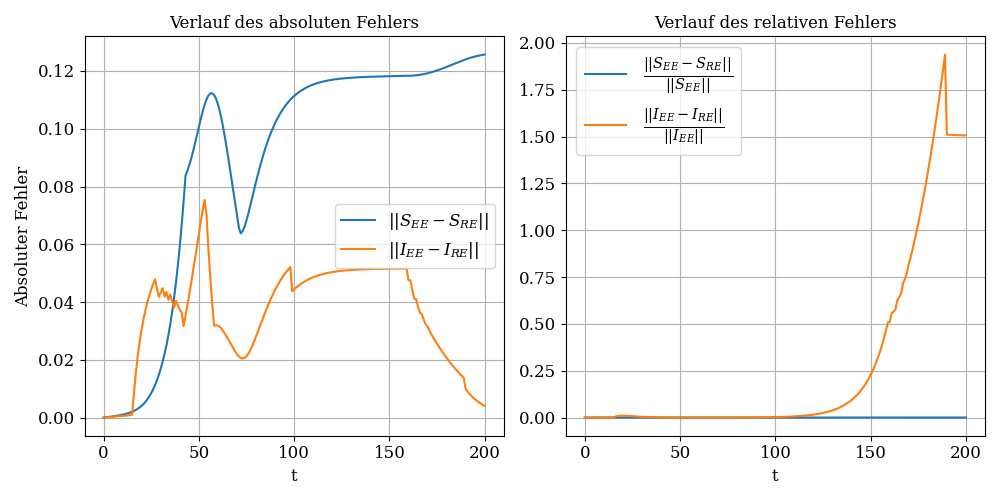

In [22]:
# Datenaggregation
abs_err_S = [np.linalg.norm(S_full[i]-S_ht[i].full()) for i in range(S_full.shape[0])]
abs_err_I = [np.linalg.norm(I_full[i]-I_ht[i].full()) for i in range(I_full.shape[0])]
rel_err_S = [np.linalg.norm(S_full[i]-S_ht[i].full())/np.linalg.norm(S_full[i]) for i in range(S_full.shape[0])]
rel_err_I = [np.linalg.norm(I_full[i]-I_ht[i].full())/np.linalg.norm(I_full[i]) for i in range(I_full.shape[0])]

# Plot
fig, axes = plt.subplots(nrows = 1, ncols=2, figsize=(10, 5))
ax1, ax2 = axes
xaxis = np.arange(len(abs_err_S))
ax1.plot(xaxis, abs_err_S, label="$||S_{EE}-S_{RE}||$")
ax1.plot(xaxis, abs_err_I, label="$||I_{EE}-I_{RE}||$")
ax1.legend(fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.grid()
ax1.set_xlabel("t", fontsize=12)
ax1.set_title("Verlauf des absoluten Fehlers")
ax1.set_ylabel("Absoluter Fehler", fontsize=12)
ax2.plot(xaxis, rel_err_S, label="$\\frac{||S_{EE}-S_{RE}||}{|| S_{EE}||}$")
ax2.plot(xaxis, rel_err_I, label="$\\frac{||I_{EE}-I_{RE}||}{|| I_{EE}||}$")
ax2.grid()
ax2.legend(fontsize=15)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlabel("t", fontsize=12)
ax2.set_title("Verlauf des relativen Fehlers")
fig.tight_layout(pad=1.0);

### 7) Hiearchische Ränge: RE

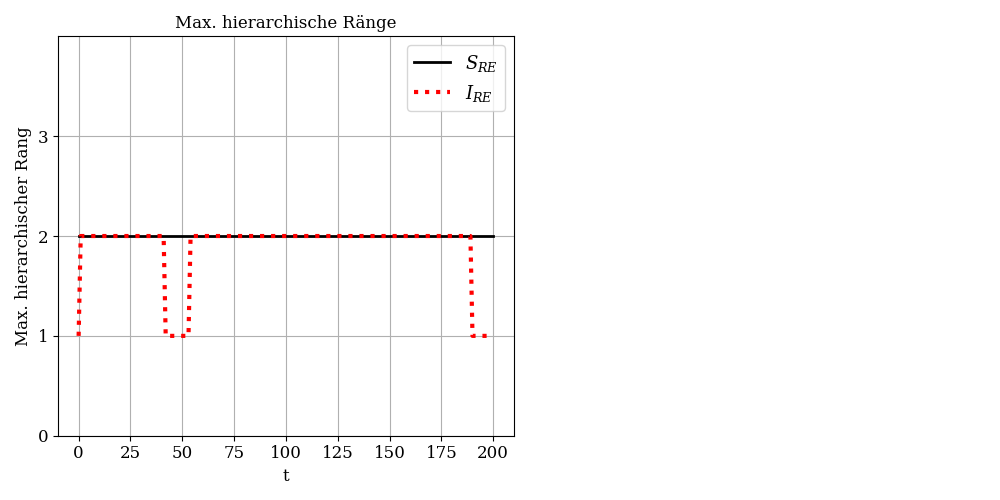

In [24]:
# Ränge
fig, axes = plt.subplots(nrows = 1, ncols=2, figsize=(10, 5))
ax1, ax2 = axes
# Plot 1: Ränge
x_axis = np.arange(Rank["S"].shape[0])
ax1.plot(x_axis, Rank["S"], label="$S_{RE}$", linewidth=2, color="black")
ax1.plot(x_axis, Rank["I"], label="$I_{RE}$", linestyle="dotted", linewidth=3, color="red")
ax1.legend(fontsize=13)
ax1.grid()
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_ylabel("Max. hierarchischer Rang", fontsize=12)
ax1.set_ylim([0,4])
ax1.set_yticks([0,1,2,3], [0,1,2,3])
ax1.set_xlabel("t", fontsize=12)
ax1.set_title("Max. hierarchische Ränge")
# Plot 2: Disabled
ax2.set_visible(False)
fig.tight_layout(pad=1.0)